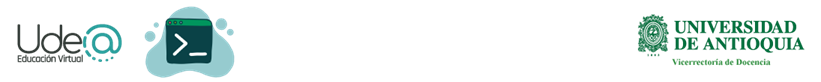

# Laboratorio #5 TDSIII
# Laboratorio Análisis de componentes principales (PCA)
## Juan Camilo Chaparro Castellanos | Sebastian Escobar Osorio
## CC 1039466438 | CC 1017231742

In [35]:
import librosa as lr
import numpy as np
from IPython.display import Audio
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import pandas as pd
import scipy as sp
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import seaborn as sbn
from sklearn.decomposition import PCA
import cv2
import os
from skimage.feature import hog, multiblock_lbp

#### A continuación se realiza el proceso sobre una de las imagenes del dataseet, iniciando por la segmentación

In [31]:
import cv2
imagen = cv2.imread('./images_redimen/06.jpg', cv2.IMREAD_GRAYSCALE)

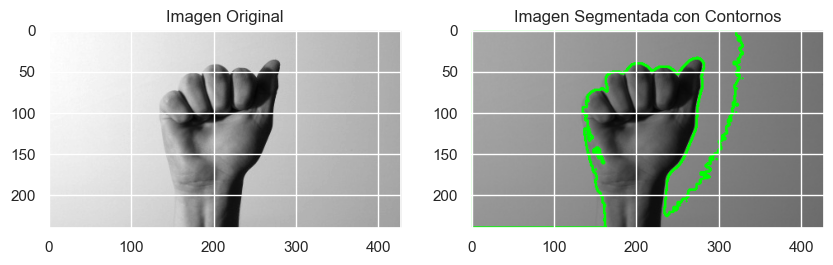

In [32]:
imagen_suavizada = cv2.GaussianBlur(imagen, (5, 5), 0) #filtro para reducir ruido
_, umbral = cv2.threshold(imagen_suavizada, 127, 255, cv2.THRESH_BINARY) #thresholding para segmentar imagen
contornos, _ = cv2.findContours(umbral, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #Contornos
imagen_contornos = cv2.cvtColor(imagen, cv2.COLOR_GRAY2BGR) # Dibujar contornos
cv2.drawContours(imagen_contornos, contornos, -1, (0, 255, 0), 2)
# Mostrar resultados
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imagen, cmap='gray')
plt.title('Imagen Original')

plt.subplot(1, 2, 2)
plt.imshow(imagen_contornos)
plt.title('Imagen Segmentada con Contornos')

plt.show()

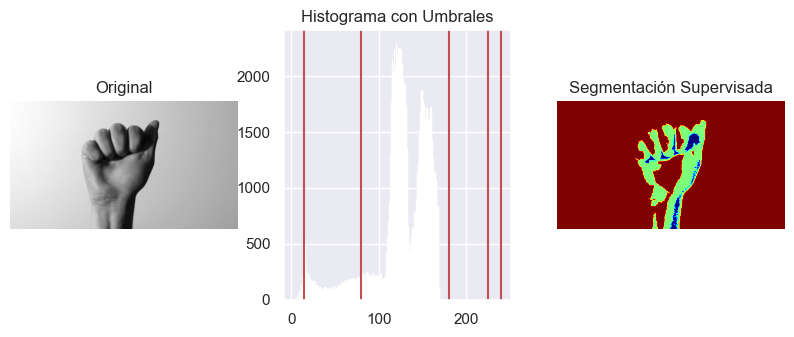

In [33]:
thresholds = [15, 80, 180, 225, 240] #umblaes

# Aplicar los umbrales a la imagen original (suavizada o no)
regions = np.digitize(imagen, bins=thresholds)

# Visualización de resultados
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# 1. Mostrar la imagen original
ax[0].imshow(imagen, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# 2. Mostrar el histograma de la imagen original con los umbrales dibujados
ax[1].hist(imagen.ravel(), bins=255, orientation='vertical')
ax[1].set_title('Histograma con Umbrales')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# 3. Mostrar la imagen segmentada con los nuevos valores asignados
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Segmentación Supervisada')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()


#### A continuación se genera el dataframe de las caracteristicas de las 12 imagenes

In [36]:
# carpeta de imágenes
carpeta_imagenes = './images_redimen'  # imagenes

# Datos
def extraer_estadisticas(img):
    stats = {
        'media': np.mean(img),
        'varianza': np.var(img),
        'asimetria': skew(img.flatten()),
        'curtosis': kurtosis(img.flatten()),
        'maximo': np.max(img),
        'minimo': np.min(img)  # Agregar valor mínimo de la imagen
    }
    return stats

# características de Fourier
def extraer_estadisticas_fourier(img):
    # Transformada de Fourier
    f_transform = np.fft.fft2(img)
    f_transform = np.fft.fftshift(f_transform)
    magnitud_espectro = np.abs(f_transform)
    
    # Datos estadisticos de Fourier
    estadisticas_fourier = {
        'medias_fourier': np.mean(magnitud_espectro),
        'varianzas_fourier': np.var(magnitud_espectro),
        'asimetria_fourier': skew(magnitud_espectro.flatten()),
        'curtosis_fourier': kurtosis(magnitud_espectro.flatten()),
        'maximos_fourier': np.max(magnitud_espectro),  # Valor máximo en Fourier
        'minimos_fourier': np.min(magnitud_espectro)   # Valor mínimo en Fourier
    }
    return estadisticas_fourier

lista_todas_caracteristicas = []  # Lista de resultados

for i in range(1, 13):
    nombre_imagen = f"{i:02}.jpg"  # nombre de cada imagen
    ruta_imagen = os.path.join(carpeta_imagenes, nombre_imagen)
    
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)  # imagen en escala de grises

    # Verificar si la imagen se ha cargado correctamente
    if imagen is None:
        print(f"No se puede abrir la imagen en la ruta: {ruta_imagen}")
        continue  # Saltar a la siguiente imagen si no se puede cargar

    # Extraer las características
    stats = extraer_estadisticas(imagen)
    estadisticas_fourier = extraer_estadisticas_fourier(imagen)
    
    all_features = {**stats, **estadisticas_fourier}  # todas las características en un diccionario
    
    # Agregar los resultados a la lista
    lista_todas_caracteristicas.append(all_features)  # agregar a la lista

df = pd.DataFrame(lista_todas_caracteristicas)  # crear dataFrame
print(df)  # mostrar el dataframe

# DataFrame en un archivo CSV
df.to_csv('caracteristicas_imagenes.csv', index=False)


         media     varianza  asimetria  curtosis  maximo  minimo  \
0   129.513493   724.911052  -1.227008  2.605568     174      14   
1   114.441832   573.772142  -2.571179  7.948776     144       2   
2   129.479809   546.733685  -2.872990  7.485317     227      12   
3   127.930744   511.040978  -2.538979  5.707745     203      16   
4   125.136390  1187.333189  -1.558457  2.528671     171       3   
5   123.741229  1250.855964  -1.473857  2.010320     170       3   
6   125.450516  1159.214315  -1.520191  2.394299     170       2   
7   107.807194  1991.270371   0.193278  0.405463     240       2   
8   124.648549  1905.713038  -0.769215 -0.158240     187       5   
9   123.049270   741.169642  -1.569694  2.776103     173      12   
10  125.031756   674.784525  -1.329471  3.373826     187       0   
11  127.352064   567.998072  -2.584453  5.816140     216      13   

    medias_fourier  varianzas_fourier  asimetria_fourier  curtosis_fourier  \
0      1442.013419       1.795383e+09

In [ ]:
df.shape

#### Se procede a aplicar PCA

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

# Cargar el DataFrame de características desde el archivo CSV
df = pd.read_csv('caracteristicas_imagenes.csv')

# Separar las características y las etiquetas
X = df.drop('etiquetas', axis=1)  # Características
y = df['etiquetas']  # Etiquetas

# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=min(X.shape[0], X.shape[1]))  # Número de componentes máximo basado en las dimensiones de X
X_pca = pca.fit_transform(X)  # Variable con los componentes principales

# Convertir los componentes principales en un DataFrame
X_pca_df = pd.DataFrame(X_pca)

# Agregar las etiquetas de nuevo al DataFrame de componentes principales
X_pca_df['etiquetas'] = y

# Mostrar el DataFrame resultante de componentes principales
print(X_pca_df)

# Guardar los componentes principales en un archivo CSV
X_pca_df.to_csv('componentes_principales.csv', index=False)


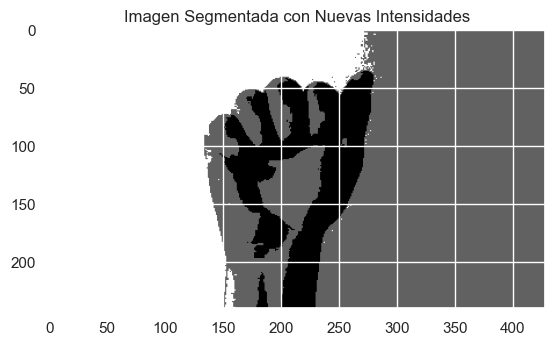

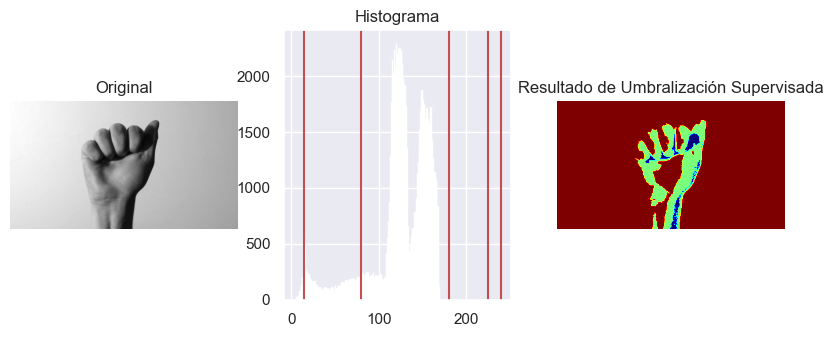

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, filters

# Cargar la imagen en escala de grises
image = cv2.imread('./images_redimen/06.jpg', cv2.IMREAD_GRAYSCALE)

# Aplicar Multi-Otsu para segmentar la imagen
thresholds = filters.threshold_multiotsu(image)
regions = np.digitize(image, bins=thresholds)

# Reasignar valores a las regiones
regions[regions == 0] = 10
regions[regions == 1] = 64
regions[regions == 2] = 150

# Mostrar la imagen segmentada con nuevas intensidades
plt.imshow(regions, cmap='gray')
plt.title('Imagen Segmentada con Nuevas Intensidades')
plt.show()

# Definir umbrales para segmentación supervisada
thresholds = [15, 80, 180, 225, 240]
regions = np.digitize(image, bins=thresholds)

# Visualización de resultados
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Imagen original
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Histograma con umbrales
ax[1].hist(image.ravel(), bins=255, orientation='vertical')  # Asegura orientación
ax[1].set_title('Histograma')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Imagen segmentada usando los umbrales supervisados
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Resultado de Umbralización Supervisada')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()


#### 1. Proyección a 2 componentes:

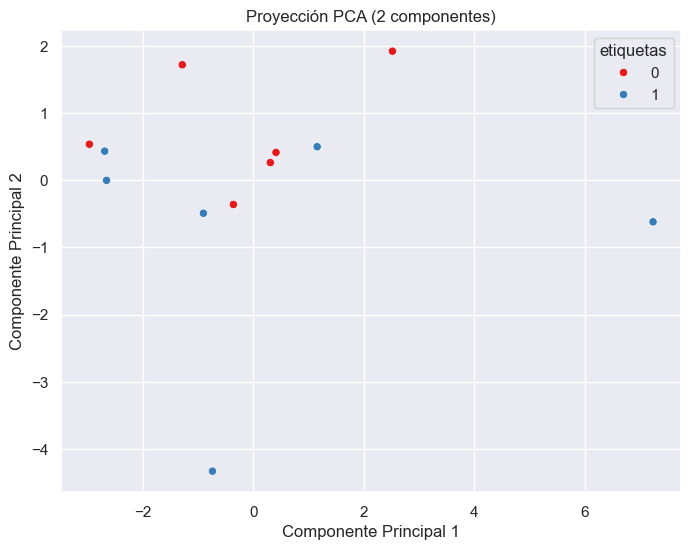

Varianza explicada por las dos primeras componentes: [0.60221329 0.1885115 ]
Porcentaje de varianza total explicada por las dos primeras componentes: 0.7907247889167981


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
df = pd.read_csv('caracteristicas_imagenes.csv')

# Establecer características y etiquetas
# Reemplaza con las etiquetas correctas.
df['etiquetas'] = [0, 1] * (len(df) // 2)  # Cambiar según las etiquetas reales

X = df.drop('etiquetas', axis=1)  # Características
y = df['etiquetas']  # Etiquetas

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA con 2 componentes
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

# Graficar las primeras 2 componentes
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=y, palette='Set1')
plt.title('Proyección PCA (2 componentes)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# Varianza explicada por las 2 componentes principales
varianza_explicada_2 = pca_2.explained_variance_ratio_
print(f"Varianza explicada por las dos primeras componentes: {varianza_explicada_2}")
print(f"Porcentaje de varianza total explicada por las dos primeras componentes: {np.sum(varianza_explicada_2)}")


#### Proyección a 5 componentes:

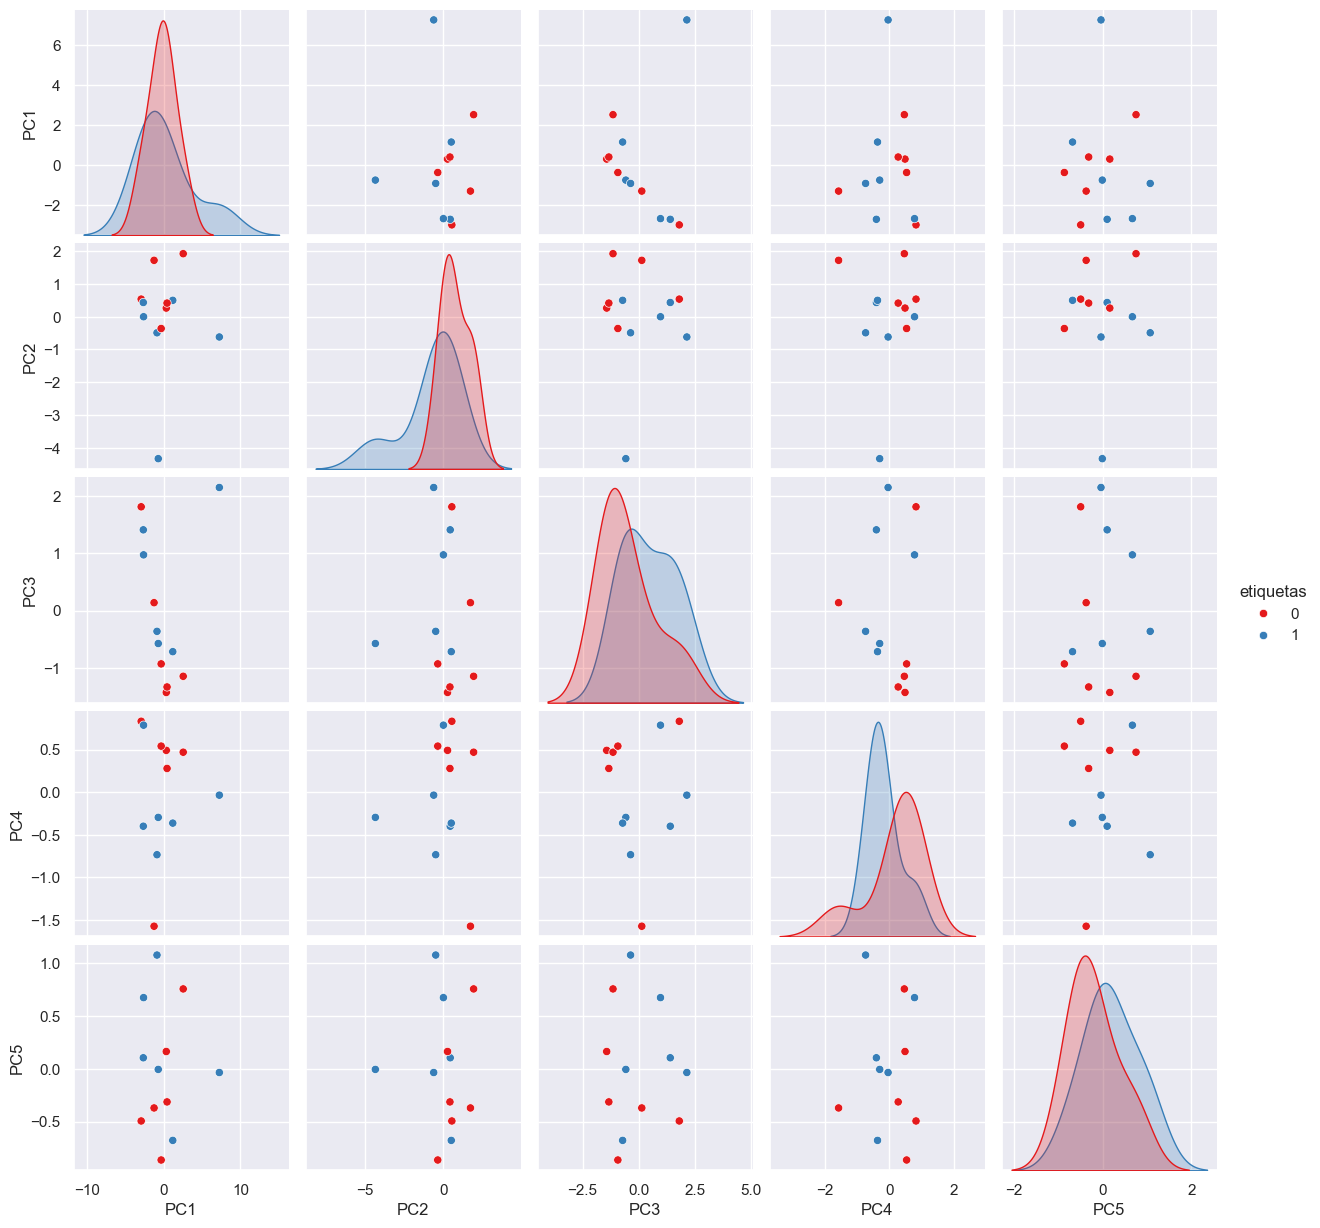

Varianza explicada por las cinco primeras componentes: [0.60221329 0.1885115  0.12347794 0.0384679  0.02702739]
Porcentaje de varianza total explicada por las cinco primeras componentes: 0.979698010300936


In [45]:
# PCA con 5 componentes
pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_scaled)

# Pairplot para los 5 componentes principales
df_pca_5 = pd.DataFrame(X_pca_5, columns=[f'PC{i+1}' for i in range(5)])
df_pca_5['etiquetas'] = y
sns.pairplot(df_pca_5, hue='etiquetas', palette='Set1')
plt.show()

# Varianza explicada por las 5 componentes principales
varianza_explicada_5 = pca_5.explained_variance_ratio_
print(f"Varianza explicada por las cinco primeras componentes: {varianza_explicada_5}")
print(f"Porcentaje de varianza total explicada por las cinco primeras componentes: {np.sum(varianza_explicada_5)}")


#### 3. Análisis de varianza acumulada:

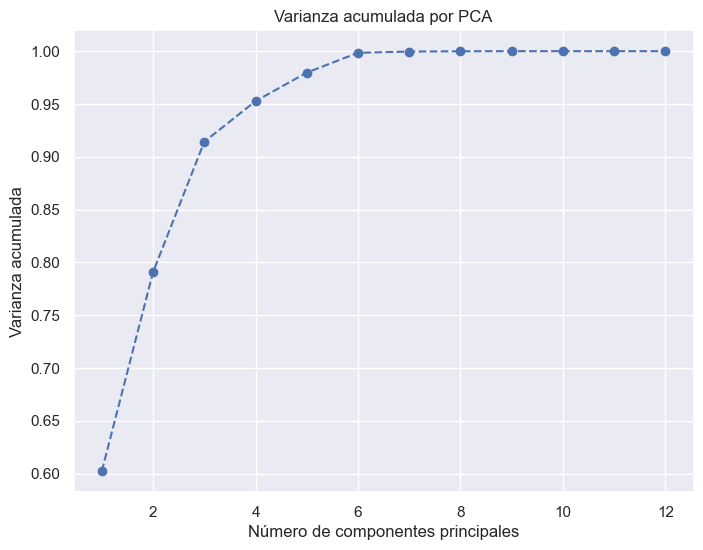

Componentes necesarios para el 90% de la varianza: 3
Componentes necesarios para el 95% de la varianza: 4
Dimensionalidad reducida en 9 componentes al preservar el 90% de la varianza.


In [47]:
# PCA con todas las características
pca_full = PCA(n_components=X.shape[1])
X_pca_full = pca_full.fit_transform(X_scaled)

# Varianza acumulada
varianza_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

# Graficar la varianza acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, X.shape[1] + 1), varianza_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada por PCA')
plt.grid(True)
plt.show()

# Encontrar el número de componentes necesarios para el 90% y 95% de la varianza
componentes_90 = np.argmax(varianza_acumulada >= 0.90) + 1
componentes_95 = np.argmax(varianza_acumulada >= 0.95) + 1

print(f"Componentes necesarios para el 90% de la varianza: {componentes_90}")
print(f"Componentes necesarios para el 95% de la varianza: {componentes_95}")
print(f"Dimensionalidad reducida en {X.shape[1] - componentes_90} componentes al preservar el 90% de la varianza.")
